### These plots were created using the Bokeh and Matplotlib libraries.

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
from bokeh.plotting import figure, output_file, show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker, LogTicker, ContinuousTicker, AdaptiveTicker,
    PrintfTickFormatter,
    ColorBar,
    FactorRange
)
import bokeh.palettes
from bokeh.transform import factor_cmap
from wordcloud import WordCloud, STOPWORDS
from math import floor
from bokeh.io import output_notebook
from bokeh.models import NumeralTickFormatter
from bokeh.resources import CDN
from bokeh.embed import file_html

%config InlineBackend.figure_format = 'retina'

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
data = pd.read_csv("../data/cleaned_data.csv")

In [4]:
data["profit"] = data["revenue"] - data["budget"]

### Temporal Pattern in Profit

In [5]:
profit_by_month_year = data[data["year"]>1990].groupby(["year","month"]).profit.mean().reset_index()
count_by_month_year = data[data["year"]>1990].groupby(["year","month"]).size().reset_index()

In [6]:
profit_by_month_year[:3]

,year,month,profit
0,1991,1,-7103420.0
1,1991,2,253742922.0
2,1991,3,24708446.5


In [7]:
newdata = ColumnDataSource(profit_by_month_year)

mapper = LinearColorMapper(palette=bokeh.palettes.RdBu[9], 
                           low=profit_by_month_year["profit"].min(), high=profit_by_month_year["profit"].max())


hover = HoverTool(
    tooltips=[
        ("profit", "@profit{$,}"),
    ]
)    

TOOLS = [hover,"save,pan,box_zoom,reset,wheel_zoom"]


p = figure(x_axis_label = 'Year', 
           y_axis_label = 'Month',
           tools=TOOLS,
           plot_width = 900)

p.rect(x="year", y="month",width=1, height=1,source = newdata,
       fill_color={'field': 'profit', 'transform': mapper})

color_bar = ColorBar(color_mapper=mapper, location=(20, 0), label_standoff=18,
                     ticker= AdaptiveTicker(), formatter = NumeralTickFormatter(format="$,") )

p.add_layout(color_bar, 'right')

p.title.text = "Movie Profit by Year and Month"
p.title.align = "center"
p.title.text_font_size = "20px"

show(p)

### Genre Exploration

In [8]:
df1 = pd.concat([pd.Series(row['year'], row['genres'].replace('[','').replace(']','').replace("'","").split(','))              
                    for _, row in data[data["year"]>1990][["year","genres"]].iterrows()]).reset_index()
df2 = pd.concat([pd.Series(row['profit'], row['genres'].replace('[','').replace(']','').replace("'","").split(','))              
                    for _, row in data[data["year"]>1990][["profit","genres"]].iterrows()]).reset_index()

In [9]:
df1.columns = ["genres","year"]
df2.columns = ["genres","profit"]

In [10]:
df1.shape, df2.shape

((10723, 2), (10723, 2))

In [11]:
df1["profit"] = df2["profit"]
df1["genres"] = df1["genres"].apply(lambda x: x.strip())
del df2

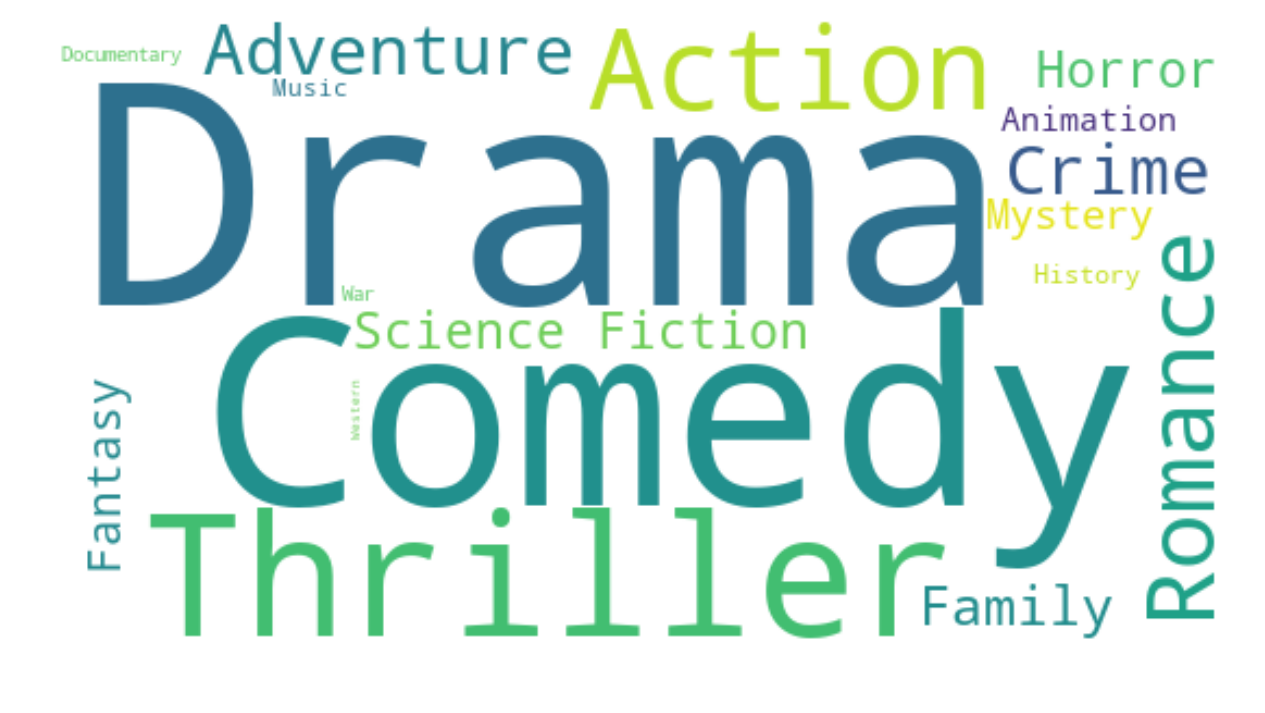

In [12]:
words = dict()
trunc_occurences = df1.groupby(["genres"]).size().sort_values(ascending=False).reset_index()
trunc_occurences.columns = ["genres", "frequency"]
for i in range(18):
    words[trunc_occurences["genres"][i]] = trunc_occurences["frequency"][i]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='white', 
                      max_words=1628,relative_scaling=0.7,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [13]:
genres = ["Drama","Comedy","Action","Adventure","Crime","Science", "Fiction","Family"]

In [14]:
grouped_data = df1[df1["genres"].isin(genres)].groupby(["genres","year"]).profit.mean().reset_index()

In [15]:
dict_group_data = {"xs":[grouped_data.loc[(grouped_data["genres"]==name),"year"].values \
                         for name in grouped_data['genres'].unique()],
                  "ys": [grouped_data.loc[(grouped_data["genres"]==name),"profit"].values\
                         for name in grouped_data['genres'].unique()],
                  "labels": grouped_data["genres"].unique(),
                  "color": bokeh.palettes.Category10[9]}

source = ColumnDataSource(dict_group_data)

hover = HoverTool(tooltips=[
    ("Genre", "@labels"),
])

p = figure(x_axis_label = 'Year', 
           y_axis_label = 'Profit', 
           width = 1000,
           tools=[hover, "save","pan","box_zoom","reset","wheel_zoom"]) 
p.yaxis[0].formatter = NumeralTickFormatter(format="$,")

p.multi_line(xs= "xs", ys= "ys", line_color= "color", source = source, legend = "labels",line_width=3)
p.legend.location = "top_left"

p.title.text = "Profit for each Genre across years"
p.title.align = "center"
p.title.text_font_size = "20px"

show(p)

/Users/mbk/anaconda/envs/fastai/lib/python3.6/site-packages/bokeh/models/sources.py:114: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('color', 9), ('labels', 6), ('xs', 6), ('ys', 6)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


### Finding Correlation between Profit & Popularity

In [16]:
data["profit"].corr(data["popularity"])

0.6206384045302814

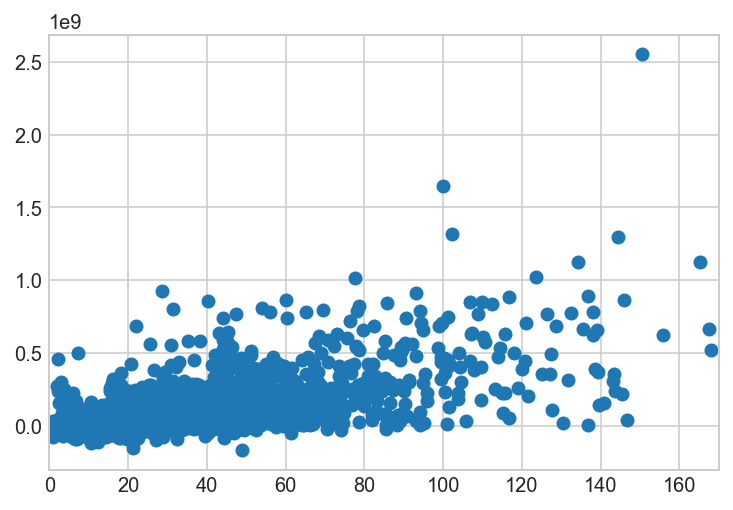

In [17]:
plt.scatter(data["popularity"],data["profit"])
plt.xlim([0,170])
plt.show()

### Decade Extracting & Checking Trends Decade-wise

In [18]:
def extract_decade(x):
    return str(floor(x/10)*10)+"s"

In [19]:
data["decade"] = data["year"].apply(extract_decade)

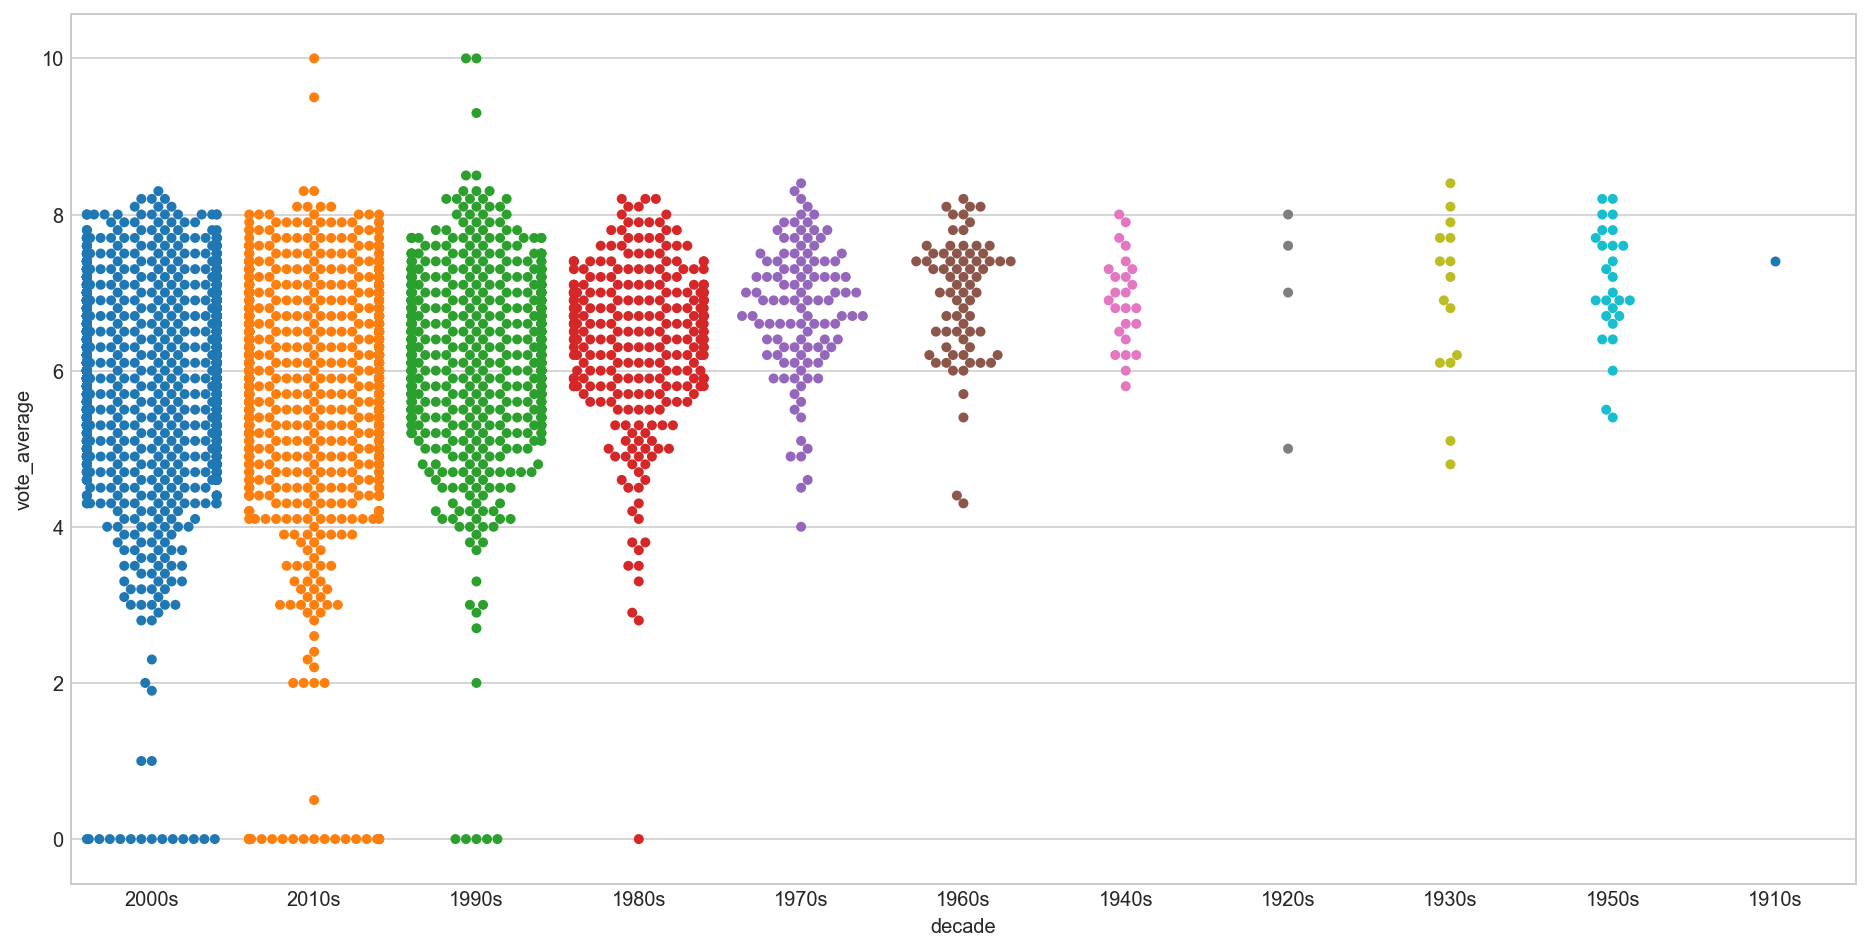

In [20]:
fig=plt.figure(figsize=(16, 8))
sns.swarmplot(x="decade", y="vote_average", data=data , palette="tab10" )
plt.show()